# Configure Notebook

In [1]:
%matplotlib notebook
%pylab
# %matplotlib inline
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina' for macs with retina display 

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


**Cloning Xana from GitLab**

What you probably have just done.

In [2]:
!git clone https://git.xfel.eu/gitlab/reiserm/Xana.git

Cloning into 'Xana'...
remote: Counting objects: 686, done.
remote: Compressing objects: 100% (555/555), done.
^Cceiving objects:  21% (145/686)   


**unpacking example data**

In [ ]:
!tar xzf ./xpcs_data.tgz

**Importing Analysis Software - Xana**

Working on _setup.py_. Later the Python-Path has not to be modified and Xana can just be imported.

## Importing Xana

In [ ]:
from Xana import Xana

# Basic Example

The example data folder contains three time series of 100nm (diameter) SiO2 nano particles dispersed in a glycerol water mixture. One data set shows indications of beam damage--the correlation functions are shifted to faster relaxation times. 

The task is to:
* calculate correlation functions of all three data sets, 
* identify the _damaged_ data set
* determine the viscosity of the solution

### Creating A Setup File

For each type of analysis a _setup_-file is needed, that contains information about the geometry (sample-detector distance, wavelength, etc.) but also about the ROIs where the analysis should be performed.

In [8]:
d = Xana(fmtstr='id10_eiger_single_edf', # format string that defines how the date are read
         sample='100nm SiO2 particles in glycerol', # optional: sample name used in data base
         maskfile='./masks/mask_structure_03.npy',
         detector='eiger500k') # file that conatains the blemish / mask 
                               # (optional: but necessary for analysis)

Connecting Xana with a data folder allows for receiving meta data information on all data sets in that folder. 

In [9]:
d.connect('./dukes100nm_glycerol/xpcs/exp320us_att0/')
d.meta

series  t_exposure  t_readout  t_latency  nframes  first  last  \
0       1     0.00032    0.00001        0.0     1500      0  1499   
1       2     0.00032    0.00001        0.0     1500      0  1499   
2       3     0.00032    0.00001        0.0     1500      0  1499   

                            master  \
0  img_eiger_0001_0000_0000.edf.gz   
1  img_eiger_0002_0000_0000.edf.gz   
2  img_eiger_0003_0000_0000.edf.gz   

                                              datdir  
0  /Users/reiserm/Xana/xpcs_example/dukes100nm_gl...  
1  /Users/reiserm/Xana/xpcs_example/dukes100nm_gl...  
2  /Users/reiserm/Xana/xpcs_example/dukes100nm_gl...

After the connection to a dataset&mdash;or a data folder with more than one dataset&mdash;has been established, the data can be accessed. In the most simple case, a 3D-array is returned (time x Pixel-X x Pixel-Y). For demonstration purposes, we read only the first 100 images by setting the last kwarg to (100,).

In [10]:
data = d.get_series(0, method='full', verbose=False, last=100)
print('\nThe returned array has the dimensions: ', data.shape)

[============================================================] 100.0%..

The returned array has the dimensions:  (101, 514, 1030)


For setting the ROIs properly, it would be convenient to have a time averaged image. The command is the same except the method kwarg has been changed to _average_. Now the command will return a list containing the average intensities, I , and the variance over time, V.

In [11]:
I, V = d.get_series(0, method='average', verbose=False, last=100)

[============================================================] 100.0%..


Now the setup can be defined. If no dict is passed to _make_setup_, the user is asked for the specific arguments. The vector qv_init contains a list of tuples. Each tuple should have the q position (or an array of q positions) as first element and the q width as second argument.

**defineqrois** needs an image, I, and the qv_init list as input parameters. The plot argument can [0,1,2], d can be between 10 and 100000. Try what happens when you play with those parameters. Try also to add the phiv_init kwarg (at the moment commented).

Added the following Q-values [nm-1]:
[0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06  0.065 0.07  0.075 0.125]


<IPython.core.display.Javascript object>


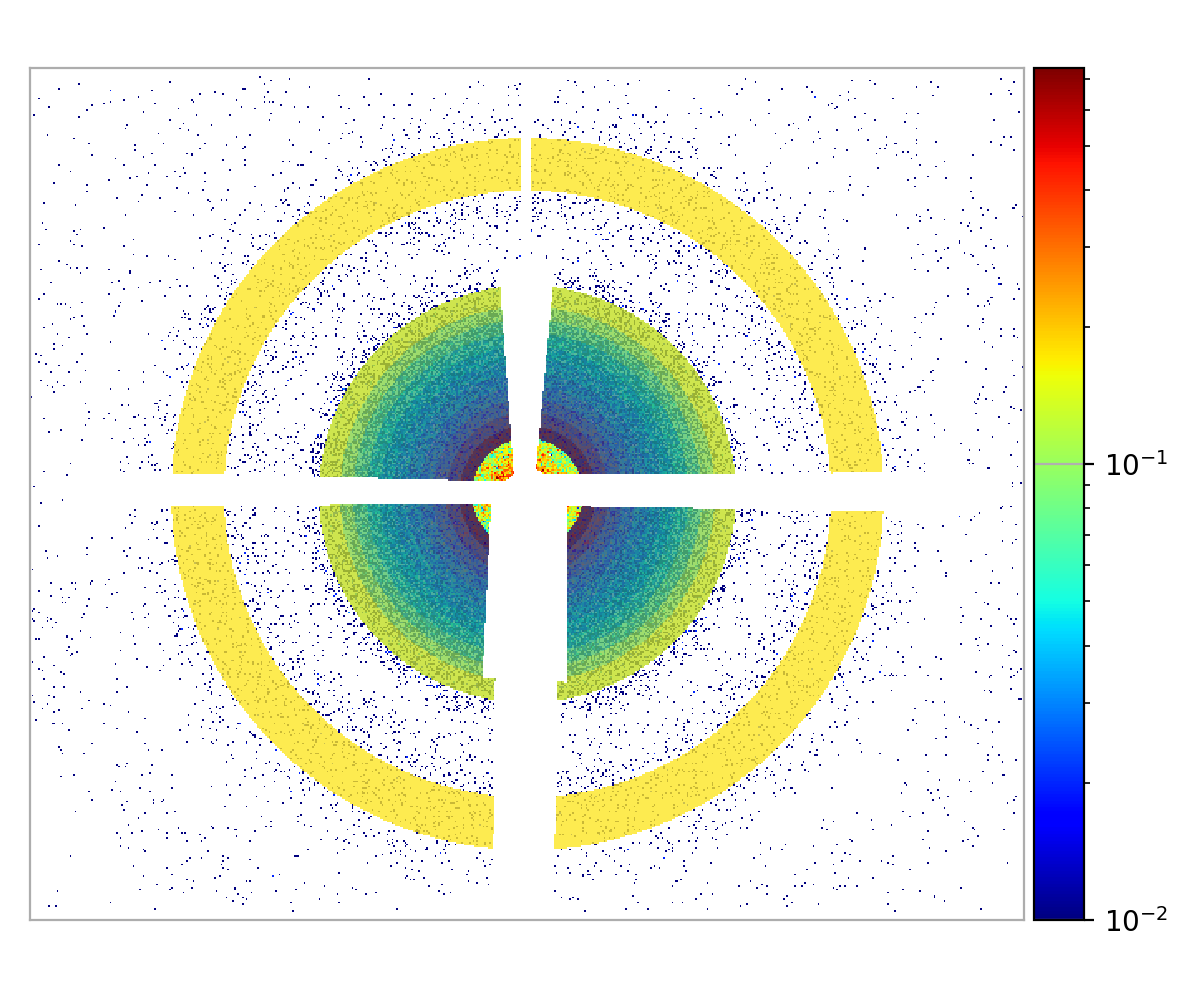

In [12]:
d.setup.make(**{'center': [516, 257], 'wavelength': 1.5, 'distance': 5})

qv_init = [(np.arange(0.025, 0.08, .005), .008),
           (.125, .02)]
phiv_init = [([10, 150], 30)]

d.defineqrois(I, qv_init=qv_init, plot=2, d=300)#, mirror=True, phiv_init=phiv_init,)

If you are content with the setup&mdash;try to stick to the default values&mdash;you can save it. The maksavdir command creates a new subfolder _setupfiles_ in the folder specified by the second argument, here in the present folder ./ . Prefix and suffix are added automatically.

In [13]:
d.mksavdir('setupfiles', './')
d.savesetup('setup_100nm_test')

Changing savdir to:
	/Users/reiserm/Xana/xpcs_example/setupfiles/
Try loading database:
	/Users/reiserm/Xana/xpcs_example/setupfiles/Analysis_db.pkl
	...loading database failed.
File exists. Save anyway? (No/Yes)	yes

Results saved to:
	/Users/reiserm/Xana/xpcs_example/setupfiles/setup_100nm_test.pkl


# Calculate Correlation Functions

Now that we have a setup file, we can proceed with the actual analysis. The setup you created is already part of Xana now. If you start from this point, you can recreate the Xana object with the setupfile as a kwarg:

In [6]:
d = Xana(fmtstr='id10_eiger_single_edf', # format string that defines how data are read
         sample='100nm SiO2 particles in glycerol', # optional: sample name used in data base
         setupfile='./setupfiles/setup_100nm_test.pkl',)

Loaded setupfile:
	/Users/reiserm/Xana/xpcs_example/setupfiles/setup_100nm_test.pkl.


... or load the setupfile:

In [7]:
d.loadsetup('./setupfiles/setup_100nm_test.pkl')

Loaded setupfile:
	/Users/reiserm/Xana/xpcs_example/setupfiles/setup_100nm_test.pkl.


In [8]:
d.connect('./dukes100nm_glycerol/xpcs/exp320us_att0/')
d.meta

series  t_exposure  t_readout  t_latency  nframes  first  last  \
0       1     0.00032    0.00001        0.0     1500      0  1499   
1       2     0.00032    0.00001        0.0     1500      0  1499   
2       3     0.00032    0.00001        0.0     1500      0  1499   

                            master  \
0  img_eiger_0001_0000_0000.edf.gz   
1  img_eiger_0002_0000_0000.edf.gz   
2  img_eiger_0003_0000_0000.edf.gz   

                                              datdir  
0  /Users/reiserm/Xana/xpcs_example/dukes100nm_gl...  
1  /Users/reiserm/Xana/xpcs_example/dukes100nm_gl...  
2  /Users/reiserm/Xana/xpcs_example/dukes100nm_gl...

we need a new folder for the analysis. Again we can use the mksavdir command

In [9]:
d.mksavdir('100nm_glycerol', './')

Changing savdir to:
	/Users/reiserm/Xana/xpcs_example/100nm_glycerol/
Try loading database:
	/Users/reiserm/Xana/xpcs_example/100nm_glycerol/Analysis_db.pkl
Successfully loaded database


The results of the analysis are stored (pickled) as dictionaries containing all necessary information on the analysis. Additionally, a database entry is added in the analysis database. The default file is Analysis_db.pkl. If that file does not exist, the database has to be initialized **after** connecting with a dataset. That is because the columns of the database are taken from the meta data table.

In [10]:
d.init_db()

File exists. Save anyway? (No/Yes)	yes

Results saved to:
	/Users/reiserm/Xana/xpcs_example/100nm_glycerol/Analysis_db.pkl


Different types of analysis can be performed as shown in the next cell. The command is allways analyze().
* The first argument is the index of the meta data table and defines the series you want to analyze. -1 means that every series is analyzed (here index [0,1,2])
* the second argument defines the type of analysis; **xpcs** uses pyxpcs, **xpcs_evt** uses the eventcorrelator
* other kwargs are specific for that type of analysis

In [ ]:
d.analyze(0, 'saxs', verbose=True, last=20)
d.analyze(0, 'xpcs', verbose=True, twotime_par=1, nprocs=4, nread_procs=1)
d.analyze(0, 'xpcs_evt', verbose=True, nprocs=4, nread_procs=1)
d.analyze(0, 'xsvs', verbose=True, nbins=64, nprocs=4, nread_procs=1)

# Data Interpretation

For plotting the results we need an Xana object and to load the analysis database. The Xana instance is then passed to Soq, CorrFunc or VisbFunc for data visualization and fitting. But that is a story for another day...

## Loading Data Base

In [7]:
d = Xana(setupfile='./setupfiles/setup_100nm_test.pkl')
d.load_db('./100nm_glycerol/Analysis_db.pkl')

Loaded setupfile:
	/Users/reiserm/Xana/xpcs_example/setupfiles/setup_100nm_test.pkl.
Try loading database:
	/Users/reiserm/Xana/xpcs_example/100nm_glycerol/Analysis_db.pkl
Successfully loaded database


The database can be accessed by the `db` property of the Xana instance.

In [ ]:
d.db

## SAXS

In [26]:
from Xana import Soq

In [ ]:
s = Soq(d)
s.plot_soq(0, Ae=0,)

## XPCS

In [31]:
from Xana import CorrFunc

In [39]:
d.db['use'] = True

Merged g2 functions:  [0.00032] (exposure times)
                      [2] (number of correlation functions)
                      [3000] (total number of images)


<IPython.core.display.Javascript object>


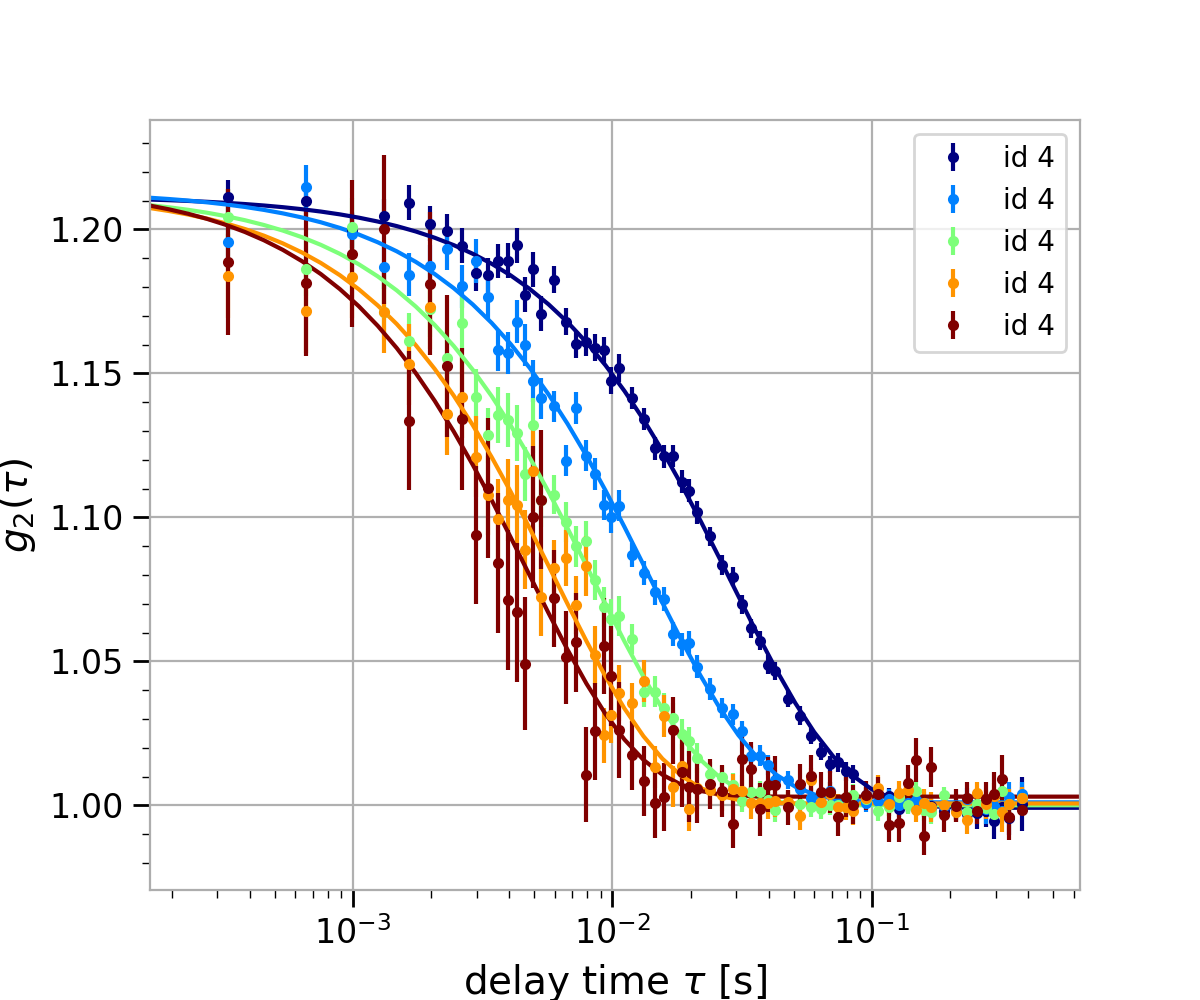

In [56]:
# initializing CorrFunc instance
g = CorrFunc(d)

# searching data base for xpcs measurements
ind = d.db[(d.db['analysis'] == 'xpcs')
          &(d.db['use'] == True)].index.values

#loading correlation functions
g.get_g2(ind, merge='merge')

# plotting
g.nq = np.arange(5)
g.plot_g2(doplot='data_legd_fit', color_mode=1, dofit=1, fix={}, init={'t0':(.02,0, None)}, 
          fitglobal=['g0','beta'])

In [42]:
d.discard_entry(3)


Results saved to:
	/Users/reiserm/Xana/xpcs_example/100nm_glycerol/Analysis_db.pkl


In [57]:
g.rescale(normby='fit', norm_contrast=True, contrast=1, baseline=1)

<IPython.core.display.Javascript object>


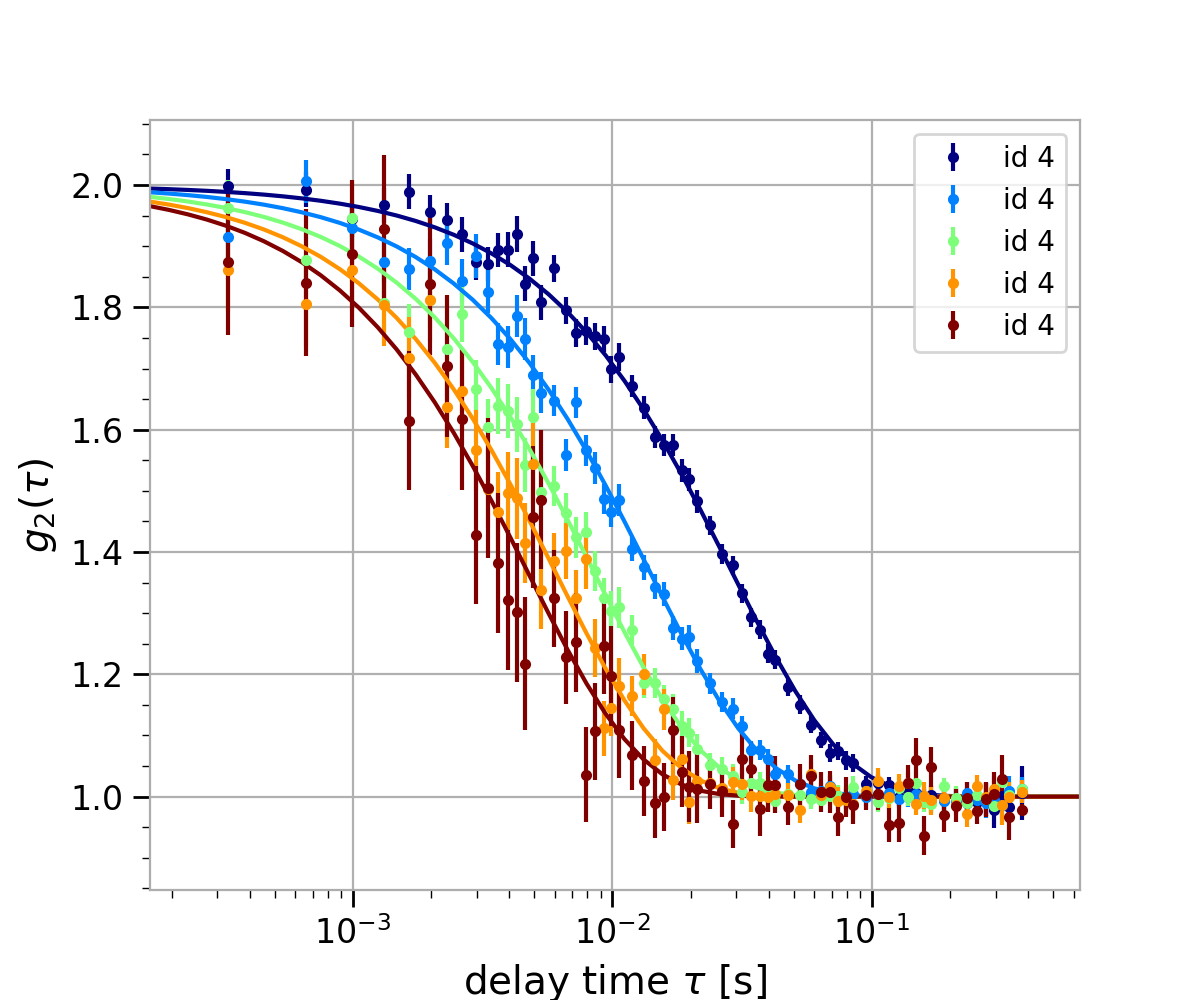

In [58]:
g.plot_g2(doplot='data_fit_legd', dofit=True, 
          fix={'a':1, 'g0':1, 'beta':1},)# init={'beta':(1,0,1), 't0':(.01,None,None), 'g0':(1,None,None)})

## Eventcorrelator

Merged g2 functions:  [0.00032] (exposure times)
                      [2] (number of correlation functions)
                      [3000] (total number of images)


<IPython.core.display.Javascript object>


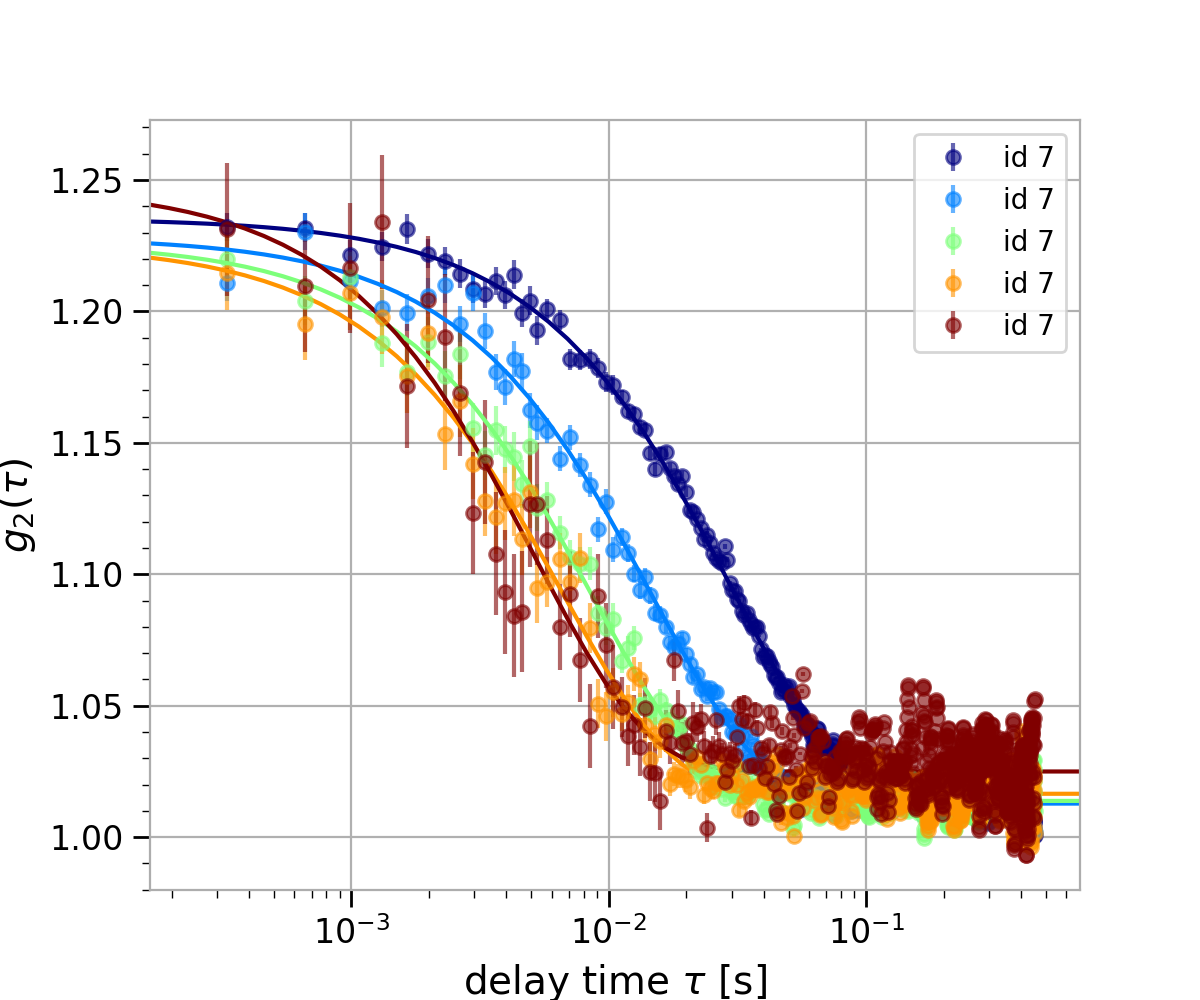

In [50]:
ge = CorrFunc(d)
ind = d.db[(d.db['analysis']=='xpcs_evt')
          &(d.db['use'])].index.values
ge.get_g2(ind, merge='merge')
ge.nq = np.arange(5)
ge.plot_g2(doplot='data_fit_legd', change_marker=1, markersize=5, alpha=.6, dofit=True, 
          fix={'g0':1,}, mode='semilogx', color_mode=0)

In [51]:
ge.rescale(normby='fit', norm_contrast=True, contrast=1, baseline=1)

<IPython.core.display.Javascript object>


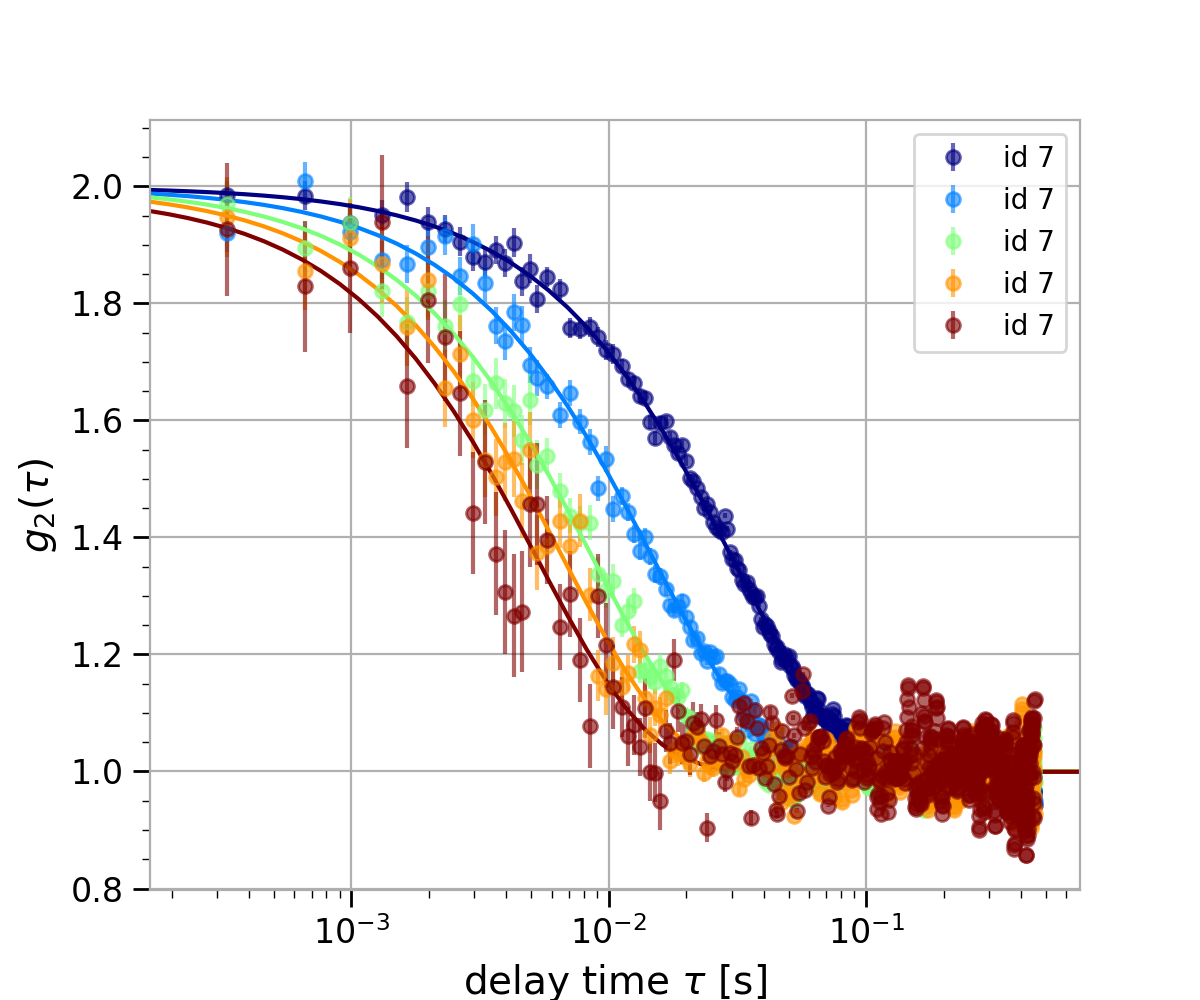

In [52]:
ge.plot_g2(doplot='data_fit_legd', change_marker=1, markersize=5, alpha=.6, dofit=True, 
          fix={'g0':1,}, mode='semilogx', color_mode=0)

### Comparing results from pyxpcs and eventcorrelator

In [59]:
gs = g + ge

In [ ]:
g.pars[0]

<IPython.core.display.Javascript object>


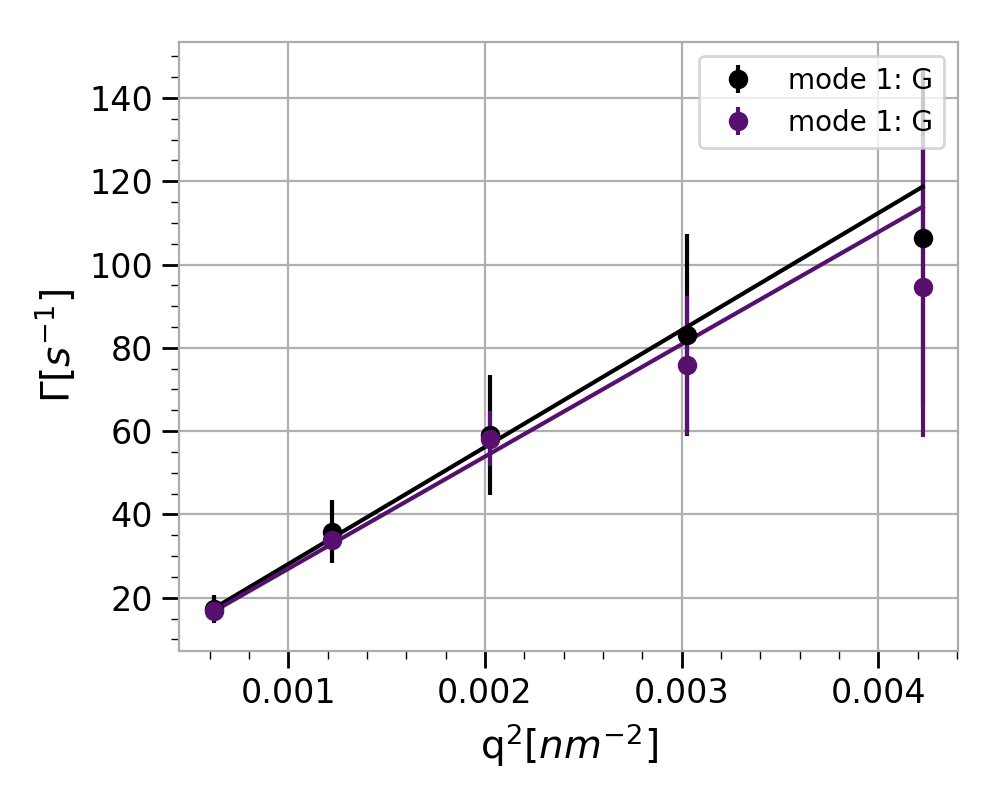


mode 1: G
eta = 154 +/- 3.4 [cP]
----------------
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 5
    # variables        = 1
    chi-square         = 0.16401097
    reduced chi-square = 0.04100274
    Akaike info crit   = -15.0862993
    Bayesian info crit = -15.4768614
[[Variables]]
    m:  28086.4842 +/- 622.854374 (2.22%) (init = 25806.76)
    b:  0 (fixed)

mode 1: G
eta = 160.5 +/- 2.2 [cP]
----------------
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 5
    # variables        = 1
    chi-square         = 0.95653443
    reduced chi-square = 0.23913361
    Akaike info crit   = -6.26938204
    Bayesian info crit = -6.65994413
[[Variables]]
    m:  26947.6443 +/- 362.657904 (1.35%) (init = 23097.45)
    b:  0 (fixed)


In [61]:
gs.plot_parameters(['G',], 
                  modes=([1],[1],),
                   alpha=(2,1,),
                   fit=('line',''),
                   fix=({'b':0}),
                   R=50e-9, viscosity=1, 
                   fit_report=1,);


<IPython.core.display.Javascript object>


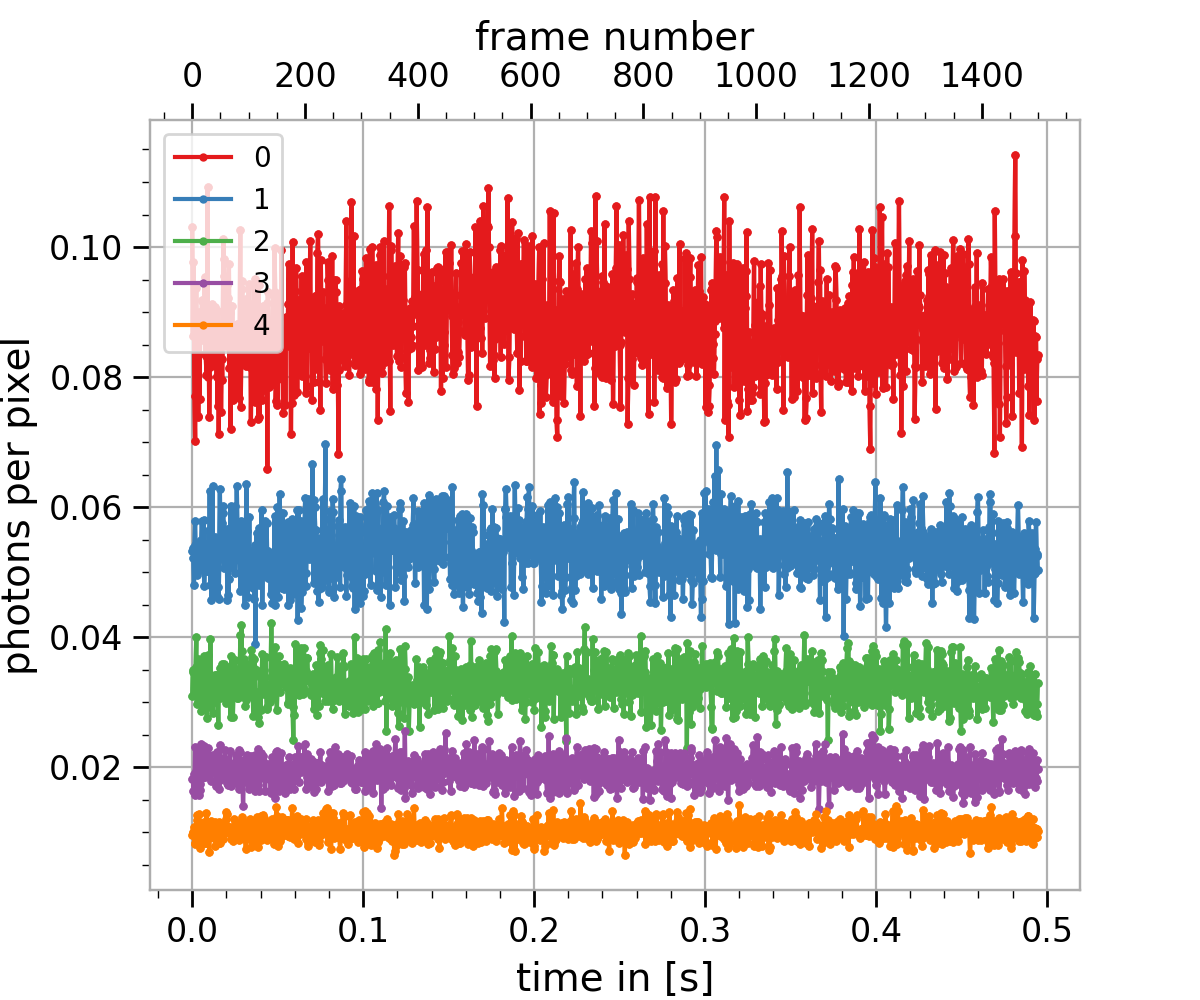

In [62]:
g.plot_trace(4)

<IPython.core.display.Javascript object>


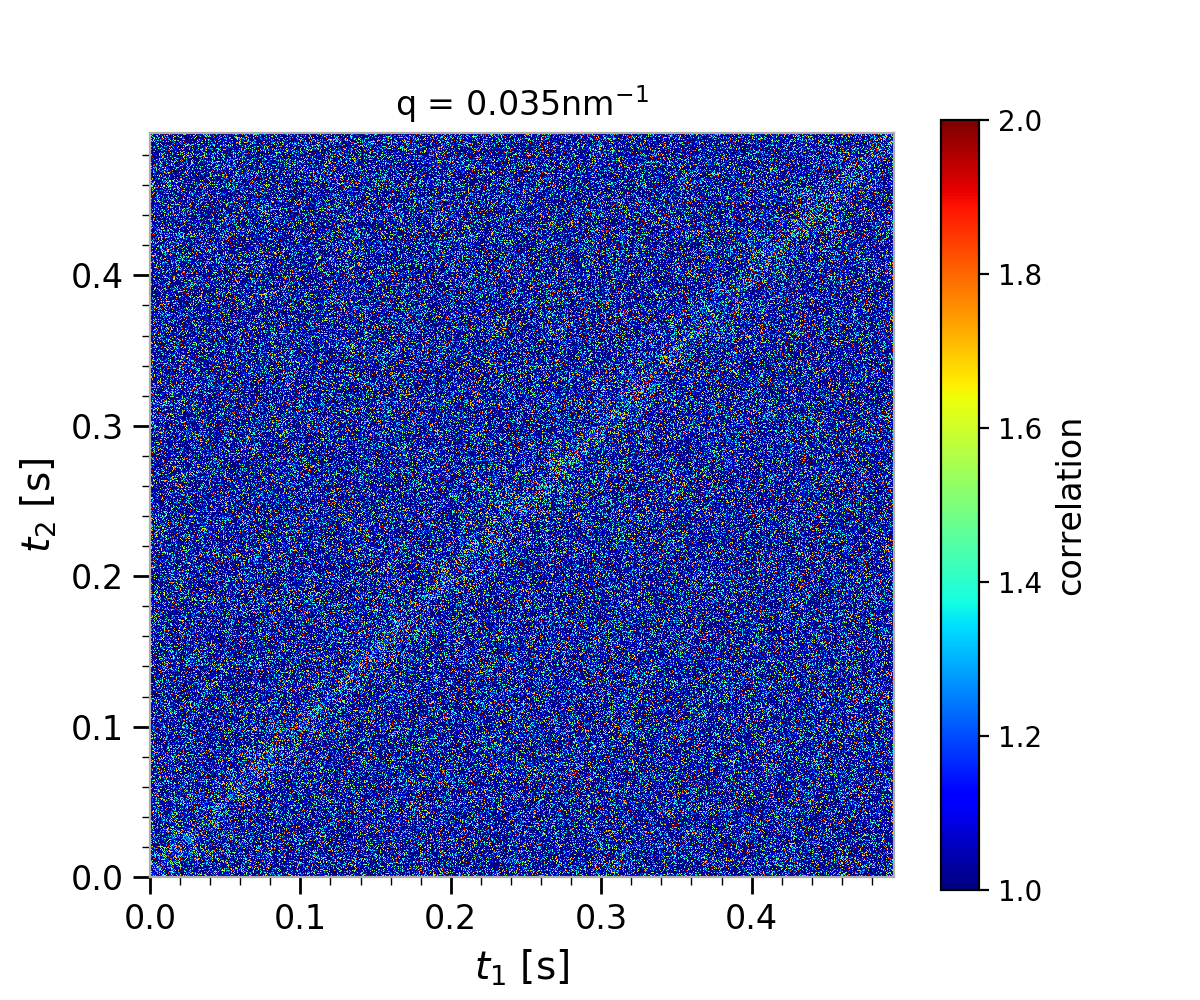

In [68]:
g.plot_twotime(3, interpolation='nearest', clim=(1,2))

## XSVS

In [69]:
from Xana import VisbFunc

Loaded probabilities of 2 series.


<IPython.core.display.Javascript object>


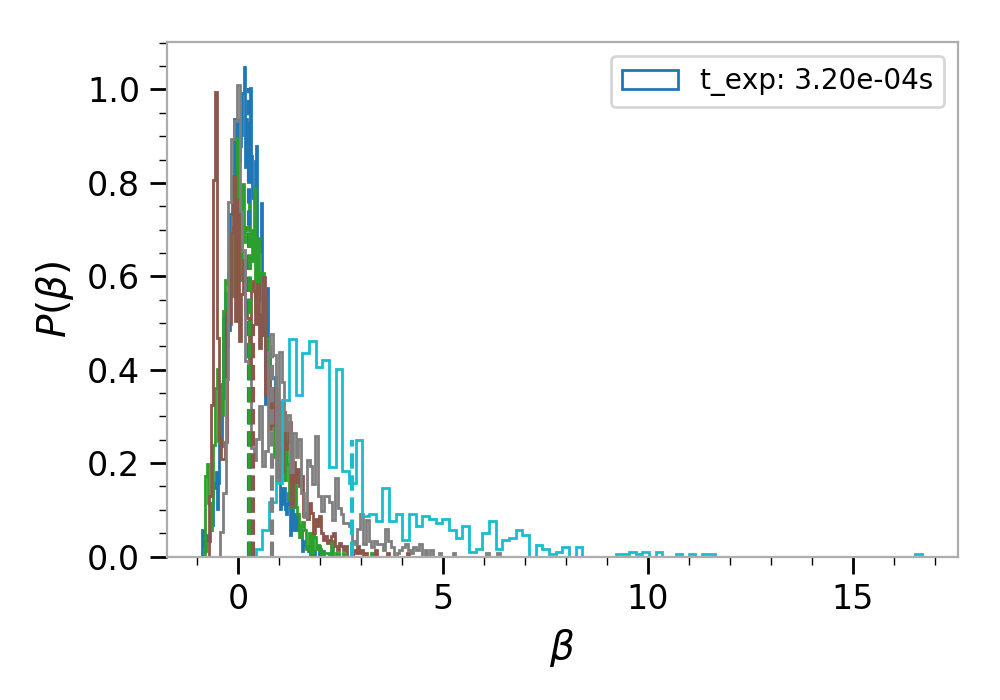

/Users/reiserm/Xana/Xana/XsvsAna/PlotContrast.py:22: RuntimeWarning: Mean of empty slice.
  arr = arr.mean(1)
/Users/reiserm/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [70]:
# initializing Visibility Func instance
v = VisbFunc(d)

# searching data base for xsvs results
ind = d.db[(d.db['analysis']=='xsvs')
          &(d.db['use'])].index.values

# loading probablities
v.get_prob(ind, merge=True)

# calculating contrast
v.calculate_contrast()

# plot histogram
v.quicklook(plot=['pbb'], nq=np.arange(5), color_mode=0, ratio=0, cmap='tab10', alpha=0.2)  

<IPython.core.display.Javascript object>


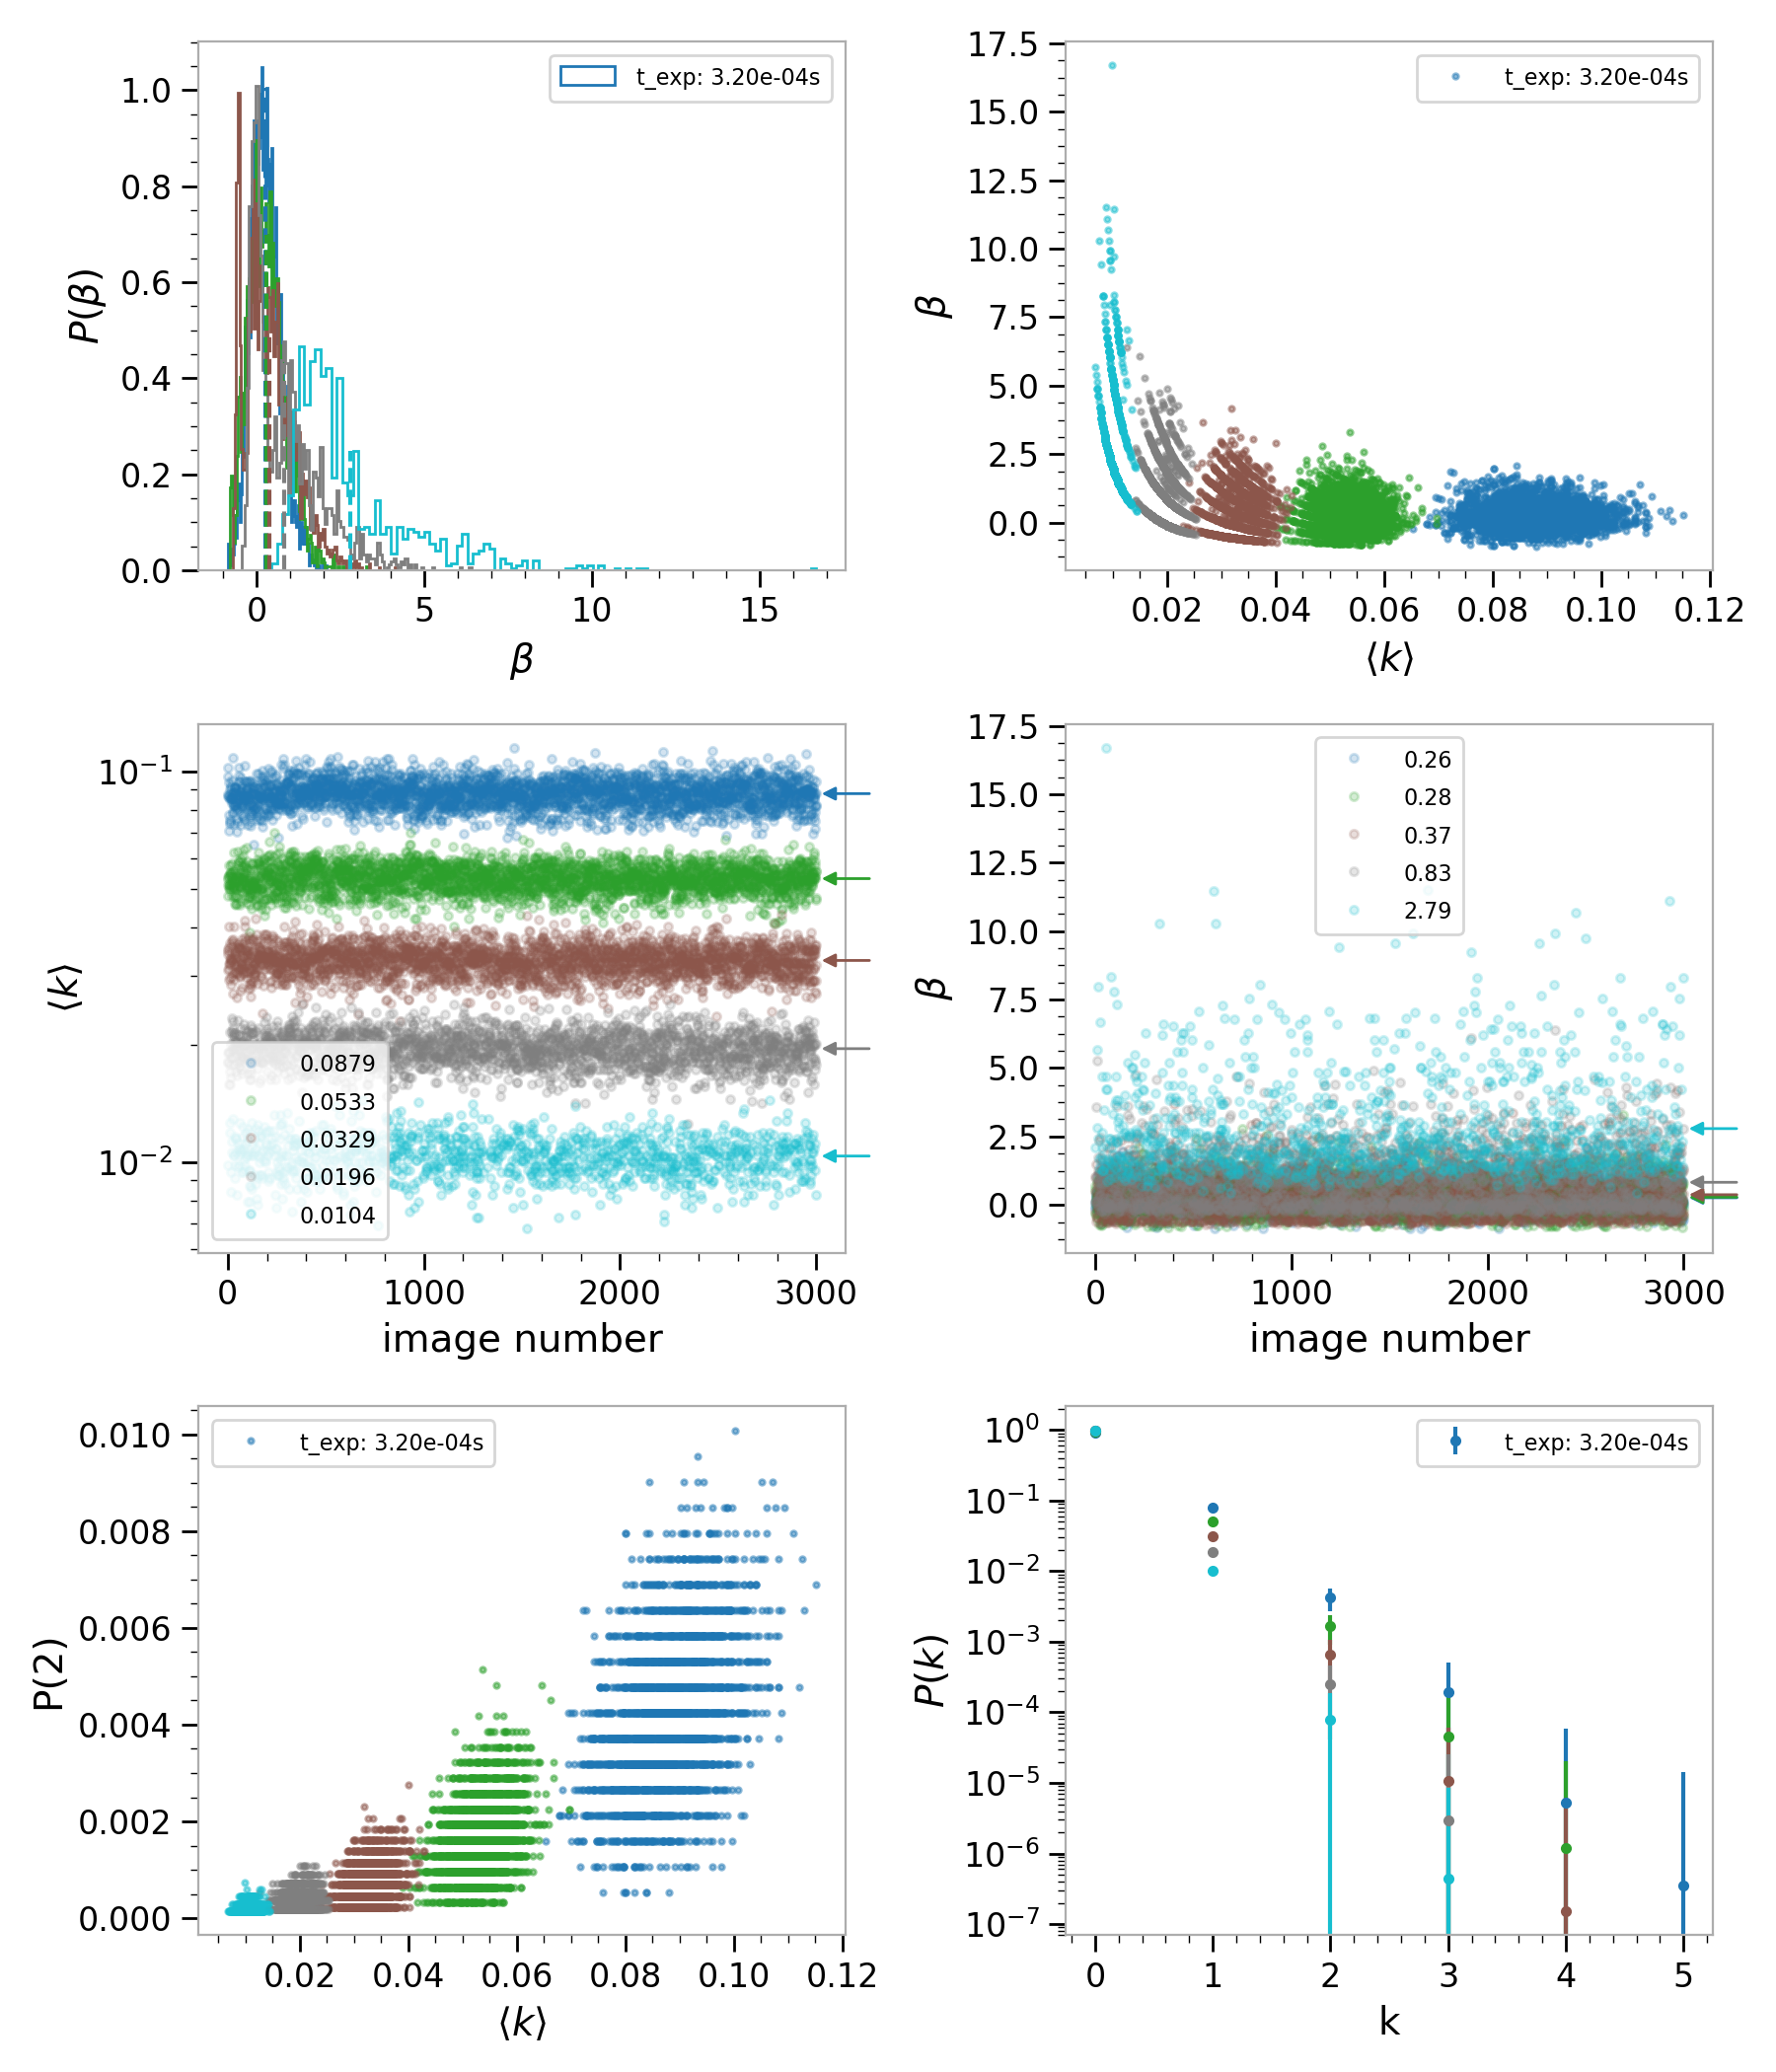

In [71]:
v.quicklook(plot=['pbb','bvkb', 'kbvi', 'bvi', 'pkvkb', 'pbk'],
                      idx=None, nq=np.arange(5), change_marker=0,
                       color_mode=1, maxlen=np.inf, ratio=0, probk=2,
                       cmap='tab10', lfs=8, total_counts=False, alpha=0.2)